<a href="https://colab.research.google.com/github/karthikmax/Segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
data = pd.read_excel('/content/sample_data/Credit Card Customer Data.xlsx')

In [ ]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [ ]:
#Drop SL_No as it adds no value
data.drop('Sl_No',axis=1,inplace=True)

In [ ]:
print("Data has {} rows and {} columns".format(data.shape[0],data.shape[1]))

Data has 660 rows and 7 columns


In [ ]:
#check if there any null or missing values
data.isnull().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [ ]:
#get information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


In [ ]:
#convert Customer Key to category.
data['Customer Key'] = data['Customer Key'].astype('category')

In [ ]:
#get a lay of the land(data)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


- Mean and Median of Total_Credit_Cards are pretty close. This could look normal
- 75% of the customers have made 5 calls. But the average calls made is about 3
- 75% of the customers have either visited the bank or went online

# EDA

### Univariate Analysis

In [ ]:
all_cols = data.iloc[:,2:].columns.tolist()
all_cols

['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

Text(0.5, 0.98, 'Histogram of numerical variables')

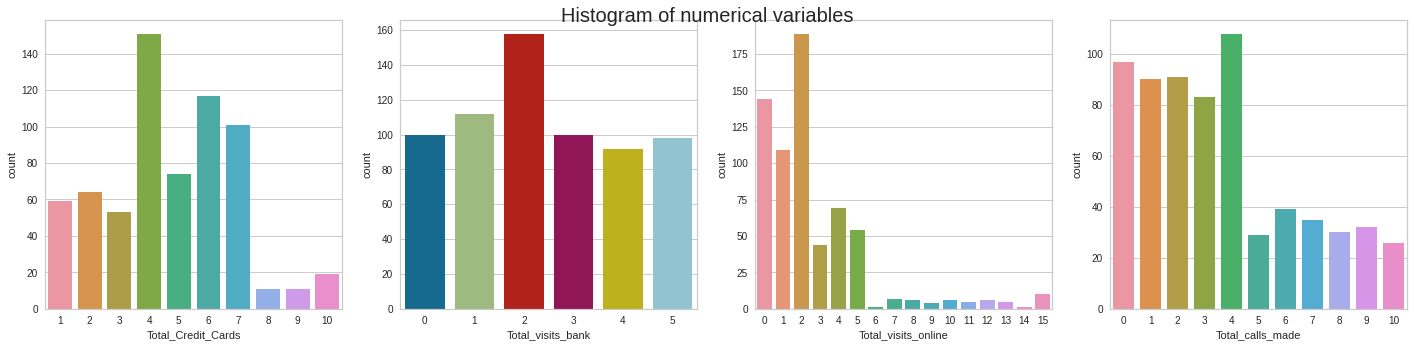

In [ ]:
fig,axes = plt.subplots(1,4,figsize=(20,5))
for i in range(len(all_cols)):
  sns.countplot(ax=axes[i],x=data[all_cols[i]],)

fig.tight_layout(pad=2.0)
fig.suptitle('Histogram of numerical variables', fontsize=20)

- Total_Credit_Cards looks normal with majority of the customers having 4 credit cards
- Total_visits_bank is slightly right skewed with most visiting at least twice
- Total_visits_online is right skewed with most visiting at least twice
- Most customers have made up to 4 calls to address any concerns or questions

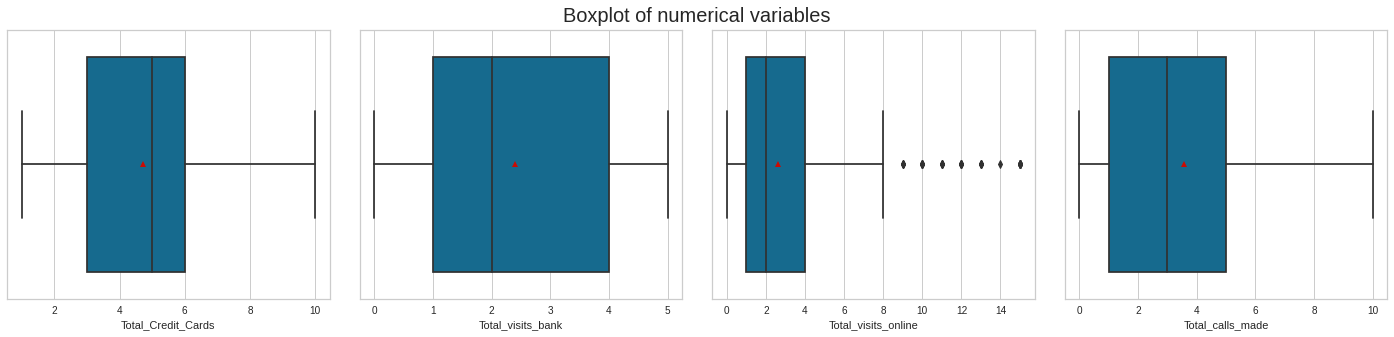

In [ ]:
fig,axes = plt.subplots(1,4,figsize=(20,5))
for i in range(len(all_cols)):
  sns.boxplot(ax=axes[i],x=data[all_cols[i]],showmeans=True)

fig.tight_layout(pad=3.0)
fig.suptitle('Boxplot of numerical variables', fontsize=20)
plt.show()

- Total_visits_online has some outliers
- Mean is pretty close to the median for all variables

### Bivariate Analysis

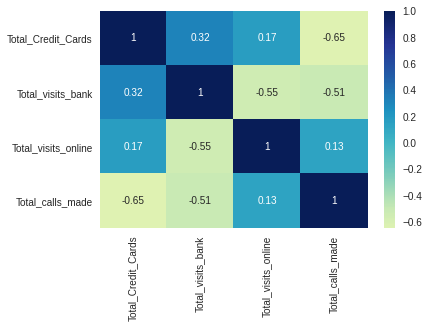

In [ ]:
#lets get correlation heat map
sns.heatmap(data[all_cols].corr(),annot=True,center=0,cbar=True,cmap='YlGnBu')
plt.show()

- Total Calls Made is negatively correlated with Total Credit Cards
- Total Visits Online is negatively correlated with Total Visits Bank, which makes sense. If a customer can check something online, they wouldn't have to go to the bank

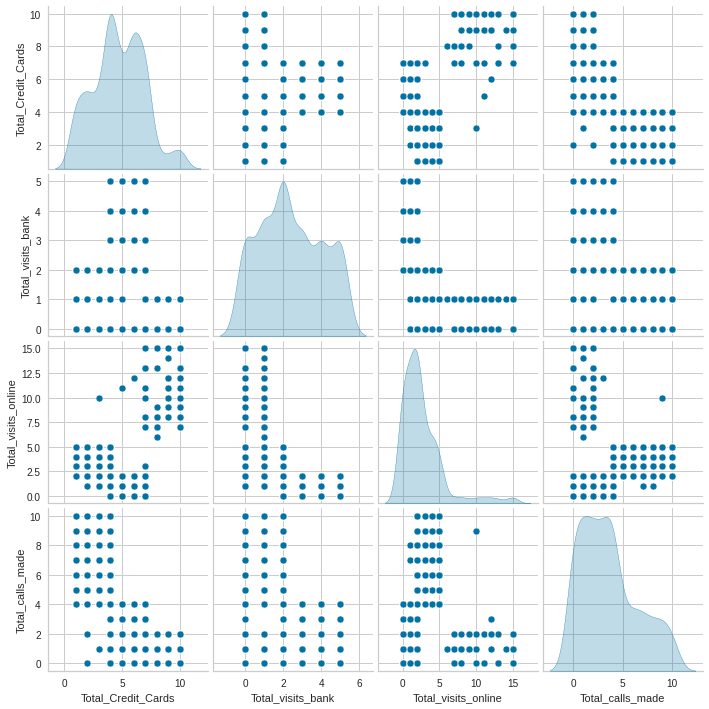

In [ ]:
sns.pairplot(data[all_cols],diag_kind='kde')
plt.show()

 - Total Credit Cards seems to have 3 modes
 - Total Calls Made seems to be bimodal 

# Clustering

### Scale Variables

In [ ]:
# Scaling the data set before clustering
data_attr = data.iloc[:,1:]
data_scaled = data_attr.apply(zscore)

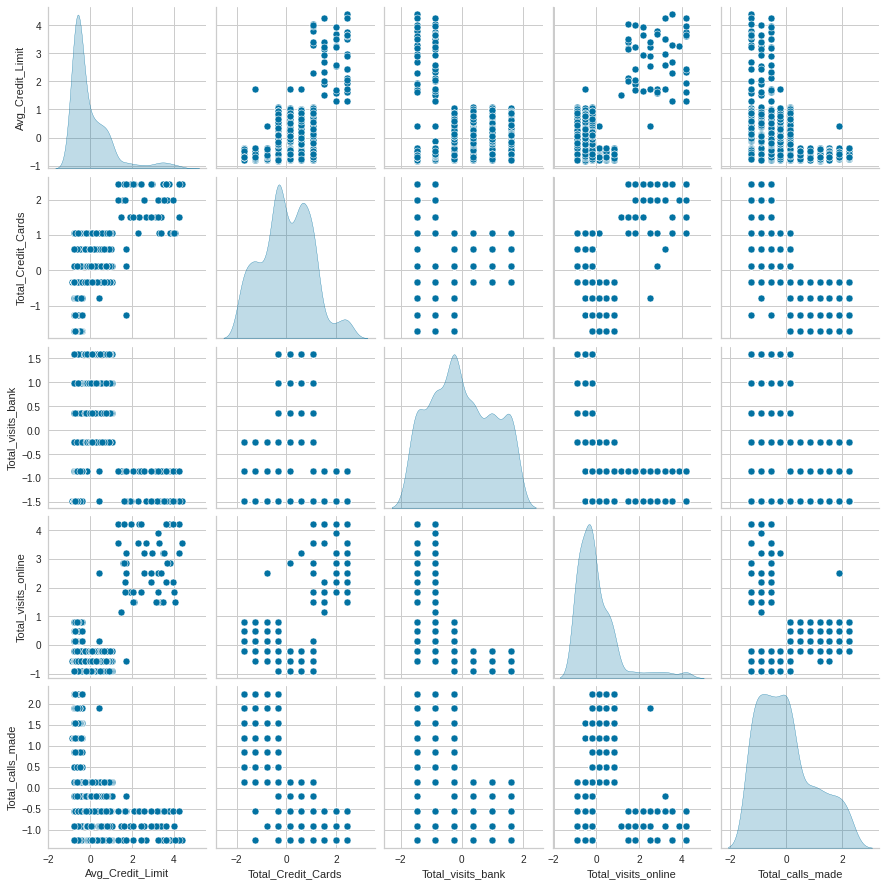

In [ ]:
#lets get pairpl0t with scaled variables
sns.pairplot(data_scaled,diag_kind='kde')
plt.show()

- This looks same as pre-scaled data, which is expected

### Elbow Method

#### Using 'euclidean' metric

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774463
Number of Clusters: 5 	Average Distortion: 0.990765495413447
Number of Clusters: 6 	Average Distortion: 0.9429789712808515
Number of Clusters: 7 	Average Distortion: 0.9095863893429446
Number of Clusters: 8 	Average Distortion: 0.8893546817976106
Number of Clusters: 9 	Average Distortion: 0.8664932647549735


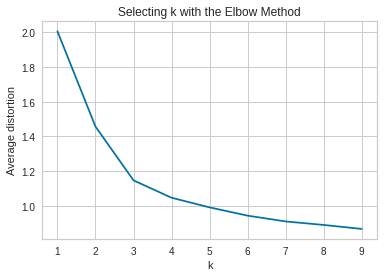

In [ ]:
#lets define range for clusters
clusters = range(1,10)
meanDistortions = []

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(data_scaled)
    prediction=model.predict(data_scaled)
    distortions=sum(np.min(cdist(data_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / data_scaled.shape[0]
    meanDistortions.append(distortions)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortions)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()


Maybe 3 or 4 clusters could be good

#### Using 'chebyshev' metric

Number of Clusters: 1 	Average Distortion: 1.4365849336346115
Number of Clusters: 2 	Average Distortion: 1.0206481347701957
Number of Clusters: 3 	Average Distortion: 0.8198780601622451
Number of Clusters: 4 	Average Distortion: 0.746495947618758
Number of Clusters: 5 	Average Distortion: 0.7012621124905623
Number of Clusters: 6 	Average Distortion: 0.673064608182405
Number of Clusters: 7 	Average Distortion: 0.6499043369558304
Number of Clusters: 8 	Average Distortion: 0.6320205631532368
Number of Clusters: 9 	Average Distortion: 0.616955881388998


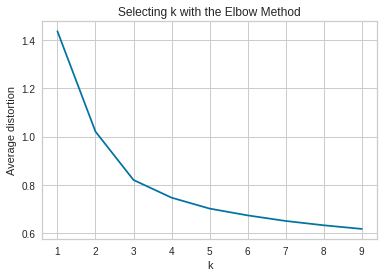

In [ ]:
#lets define range for clusters
clusters = range(1,10)
meanDistortions = []

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(data_scaled)
    prediction=model.predict(data_scaled)
    distortions=sum(np.min(cdist(data_scaled, model.cluster_centers_, 'chebyshev'), axis=1)) / data_scaled.shape[0]
    meanDistortions.append(distortions)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortions)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

- Looks like 3 or 4 clusters would be good

#### Lets try with 3 clusters

In [ ]:
#lets try with 3 clusters
model_k3 = KMeans(3)
model_k3.fit(data_scaled)
prediction = model_k3.predict(data_scaled)

#Append the prediction 
data["GROUP"] = prediction
data_scaled["GROUP"] = prediction
print("Groups Assigned : \n")
data.head()

Groups Assigned : 



,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,87073,100000,2,1,1,0,2
1,38414,50000,3,0,10,9,1
2,17341,50000,7,1,3,4,2
3,40496,30000,5,1,1,4,2
4,47437,100000,6,0,12,3,0


In [ ]:
data['GROUP'].value_counts()

2    386
1    224
0     50
Name: GROUP, dtype: int64

#### Lets try with 4 clusters

In [ ]:
#lets try with 4 clusters
model_k4 = KMeans(4)
model_k4.fit(data_scaled)
prediction = model_k4.predict(data_scaled)

#Append the prediction 
data["GROUP4"] = prediction
data_scaled["GROUP4"] = prediction
print("Groups Assigned : \n")
data.head()

Groups Assigned : 



,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels,GROUP4
0,87073,100000,2,1,1,0,0,0
1,38414,50000,3,0,10,9,2,1
2,17341,50000,7,1,3,4,0,0
3,40496,30000,5,1,1,4,0,0
4,47437,100000,6,0,12,3,1,2


In [ ]:
data['GROUP4'].value_counts()

1    223
0    197
3    190
2     50
Name: GROUP4, dtype: int64

In [ ]:
#lets try with 5 clusters
model_k5 = KMeans(5)
model_k5.fit(data_scaled)
prediction = model_k5.predict(data_scaled)

#Append the prediction 
data["GROUP5"] = prediction
data_scaled["GROUP5"] = prediction
print("Groups Assigned : \n")
data.head()

Groups Assigned : 



,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels,GROUP4,GROUP5
0,87073,100000,2,1,1,0,0,0,2
1,38414,50000,3,0,10,9,2,1,4
2,17341,50000,7,1,3,4,0,0,2
3,40496,30000,5,1,1,4,0,0,2
4,47437,100000,6,0,12,3,1,2,3


In [ ]:
data['GROUP5'].value_counts()

2    196
1    190
0    114
4    110
3     50
Name: GROUP5, dtype: int64

- I feel 5 clusters capture better.



### Silhoutte Score

In [ ]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    kcluster = KMeans(n_clusters=n_clusters)
    preds = kcluster.fit_predict((data_scaled))
    centers = kcluster.cluster_centers_
    score = silhouette_score(data_scaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.40775713712356804)
For n_clusters = 3, silhouette score is 0.4203340870757303)
For n_clusters = 4, silhouette score is 0.5260792595896668)
For n_clusters = 5, silhouette score is 0.6383883008377969)
For n_clusters = 6, silhouette score is 0.5252996834808284)
For n_clusters = 7, silhouette score is 0.4155401930461677)
For n_clusters = 8, silhouette score is 0.38526279902226035)
For n_clusters = 9, silhouette score is 0.31667757317107)


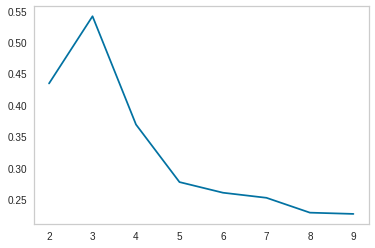

In [ ]:
plt.plot(cluster_list,sil_score)
plt.grid()

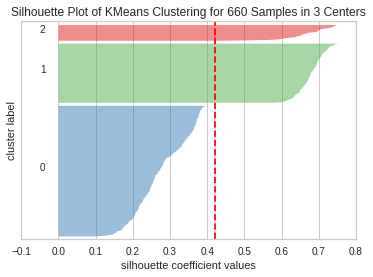

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(data_scaled)
visualizer.poof()

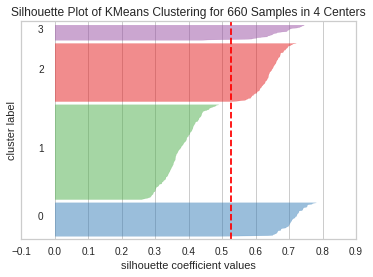

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(data_scaled) 
visualizer.poof()

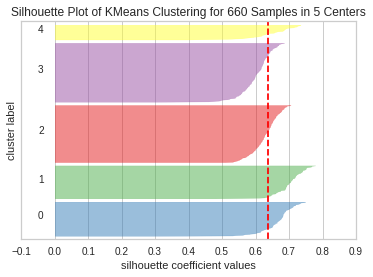

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(data_scaled) 
visualizer.poof()

I feel 5 clusters are good enough

In [ ]:
#drop the old clusters we added
data.drop(['GROUP4','GROUP5','labels'],axis=1,inplace=True)
data_scaled.drop(['GROUP4','GROUP5','GROUP'],axis=1,inplace=True)

In [ ]:
kmeans_final = KMeans(n_clusters=5, random_state=1)
kmeans_final.fit(data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [ ]:
data['kmeans_final_segments'] = kmeans_final.labels_
data_scaled['kmeans_final_segments'] = kmeans_final.labels_

### Profile

In [ ]:
kmeanscluster_profile = data.groupby('kmeans_final_segments').mean()
kmeanscluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
kmeans_final_segments,,,,,
0,11798.245614,2.438596,1.087719,3.438596,5.236842
1,12563.636364,2.381818,0.772727,3.672727,8.563636
2,31226.315789,5.478947,4.515789,1.010526,1.936842
3,36260.204082,5.551020,2.494898,0.954082,2.061224
4,141040.000000,8.740000,0.600000,10.900000,1.080000


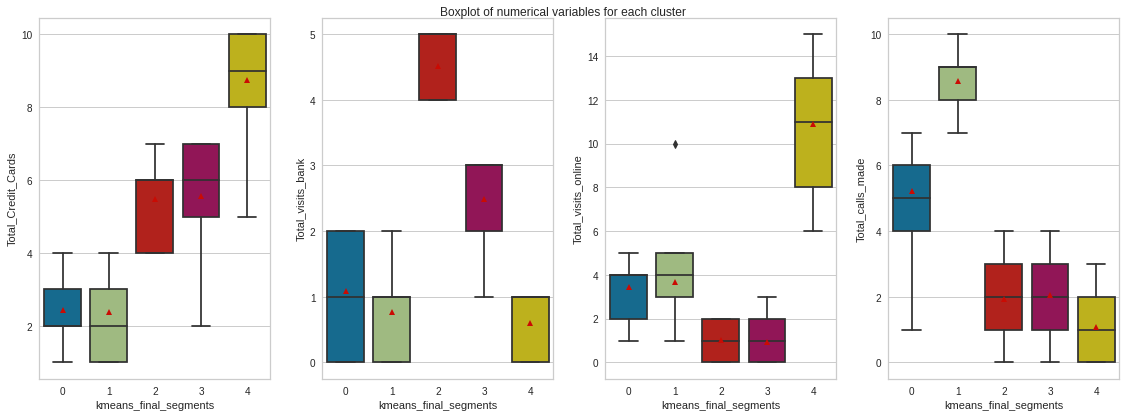

In [ ]:
fig, axes = plt.subplots(1, 4,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
for i in range(len(all_cols)):
    sns.boxplot(ax=axes[i],y=data[all_cols[i]],x=data['kmeans_final_segments'],showmeans=True)

fig.tight_layout(pad=2.0)

*   Cluster 0
        Average Credit Cards is around 3
        Total visits to the bank is up to 2
        Average visits online is around 3
        Average calls made is around 5

*   Cluster 1
        Average Credit Cards is around 3
        Total visits to the bank is up to 2
        Average visits online is around 3
        Total Calls made is pretty high



*   Cluster 2
        Average Credit Cards is around 5
        Total visits to the bank is high
        Total visits online is low
        Total Calls made is also low with an averagae of 2 calls



*   Cluster 3
        Average Credit Cards is around 5
        Total visits to the bank is preferred over calling or visiting online portal
        Total visits online is low
        Total Calls made is low as well



*   Cluster 4
        Total Credit Cards is high
        Total visits to the bank is low
        Average visits online is high
        Total Calls made is low



# Hierarchial Clustering

In [ ]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean',  linkage='average')
model.fit(data_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=5)

In [ ]:
#data.drop('GROUP',axis=1,inplace=True)

In [ ]:
data['labels'] = model.labels_
data.head(10)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,kmeans_final_segments,labels
0,87073,100000,2,1,1,0,3,3
1,38414,50000,3,0,10,9,1,4
2,17341,50000,7,1,3,4,3,2
3,40496,30000,5,1,1,4,3,2
4,47437,100000,6,0,12,3,4,0
5,58634,20000,3,0,1,8,1,1
6,48370,100000,5,0,11,2,4,0
7,37376,15000,3,0,1,1,0,1
8,82490,5000,2,0,2,2,0,1
9,44770,3000,4,0,1,7,1,1


In [ ]:
data_clusters = data.groupby(['labels'])
data_clusters.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,kmeans_final_segments
labels,,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000,4.000000
1,12004.484305,2.408072,0.937220,3.524664,6.860987,0.488789
2,33610.389610,5.524675,3.496104,0.981818,2.005195,2.506494
3,100000.000000,2.000000,1.000000,1.000000,0.000000,3.000000
4,50000.000000,3.000000,0.000000,10.000000,9.000000,1.000000


In [ ]:
links = ['average','complete','ward']

Cophenet value for average link is 0.9373947472012446


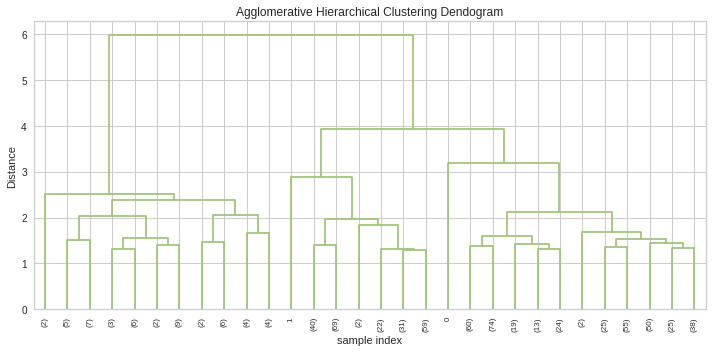

Cophenet value for complete link is 0.928876645045492


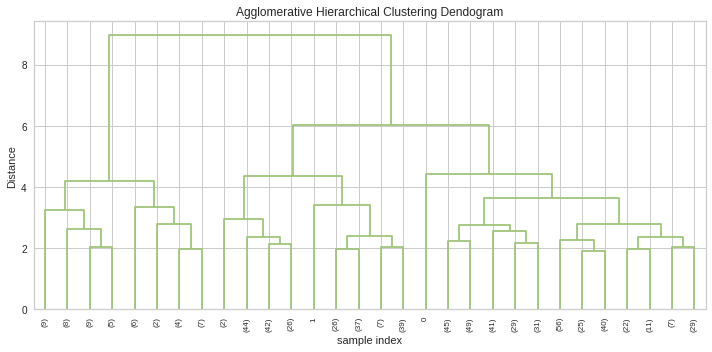

Cophenet value for ward link is 0.8035754251811738


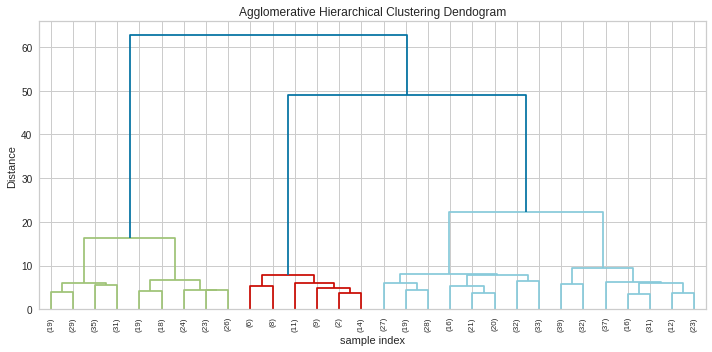

In [ ]:
for i in range(len(links)):
  linkagevalue = linkage(data_scaled, metric='euclidean', method=links[i])
  c, coph_dists = cophenet(linkagevalue , pdist(data_scaled))

  print("Cophenet value for {} link is {}".format(links[i],c))

  plt.figure(figsize=(10, 5))
  plt.title('Agglomerative Hierarchical Clustering Dendogram')
  plt.xlabel('sample index')
  plt.ylabel('Distance')
  dendrogram(linkagevalue, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8.,truncate_mode='lastp')
  plt.tight_layout()
  plt.show()

# Comparison of clusters

- Clusters 0 and 1 seem somewhat similar. They seem to have reasonable amount of cards and they visit the bank or online portal lesser. But they make more calls to enquire

- Clusters 2 and 3 consists of customers who prefer to visit bank than other means. Possibly someone who doesn't technology much

- Cluster 4 takes care of everything online. Mostly consists of younger generation who prefers to get things done online without human interaction

# K-Means vs Hierarchial

Disadvantage with K-Means clustering is it produces different results when run at different times. Hierarchial clustering results can be reproduced.

My distortion score changed slightly when I ran K-means mutliple times. However, hierarcial cannot handle large amount of data. In that scenario, K-Means is better.

# Recommendation

- Banks goal should be lower costs by trying to get customers to engage online that would reduce human interaction whether call center agents or branch employees.

- Bank can redirect questions or enquiries from cluster 0 and 1 to online.So they visit the bank branch less and save time for both the bank and customer. Bank can also save on call center costs if questions can be addressed online. 

- Bank can also make more functionality available online which may reduce customers visiting the branch.